# Chapter 4: Integrating Social and Environmental Data in Coupled Natural-Human Systems <a name="top"></a>

<div class="alert alert-info">
 [⬅️ Previous Chapter](Chapter%203.ipynb)     
</div>

![](../assets/boni.png)

Farmers make several important decisions over the course of a growing season that can have serious consequences for their livelihood. These decisions are subject to a variety of influences such as environmental variability, social norms, government policy, and socio-economic circumstances. In this module, we will explore household-level and field-level data showing variability in planting dates and rainfall, and discuss possible hypotheses for research.

The WAVES lab at UCSB installed 10 crop-monitoring weather stations in Kenya in 2015 and an additional 60 in 2018. These [in-field sensors](https://www.arable.com) go beyond traditional weather measurements  by providing spectral data to sense photosynthetic activity, acoustic detection of precipitation, net radiometry for energy budgets, IR thermometers and telemetry to build advanced analytics and precision agriculture tools. For this activity, we will use data from an older generation of devices for analyzing rainfall. 

As you've seen in the previous chapters, our field sites in the Rift Valley Province Mt. Kenya region (0.0˚N, 37.0˚E) are characterized by equatorial rainfall with a bimodal rainfall regime which peaks in the boreal spring (roughly March to May; "long rains") and boreal automumn (October and November: "short rains").  

To read more about precipitation trends around Mt. Kenya see [Schmocker et al. 2016](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/joc.4438).


## Chapter Objectives

* Create functions using python to seperate rainy seasons (define rainy seasons using functions)
* Visualize distributions of planting seasons -- check out # of farmers with one, two vs. three plantings. What was the most frequently planted week? Visualize variability in planting dates
* Hypothesize what social and environmental factors alter farmer decisions, and what impact that has on production
* Calculate likelihood of premature maize

## Read in Data

In [92]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Surveys of farmer decision making

We've been collecting data on farmer planting and harvest dates using an SMS-based survey system. A portion of thie data has been organzied within two files; `maize-plant-with-season.csv` and `maize-harvest-with-season.csv`. Let's load these files and take a look at their structure.

In [93]:
plant = pd.read_csv('../data/maize-plant-with-season.csv', date_parser='Week')
harvest = pd.read_csv('../data/maize-harvest-with-season.csv', date_parser='Week'); plant.head()

# Let's take a look at these data.
print(plant.head())
print(harvest.head())

         UID      Week Season
0  1A12DE700    4/3/17  L2017
1  1A12DE701   3/28/16  L2016
2  1A12DE702  10/31/16  S2016
3  1A12DE703    5/9/16  L2016
4  1A12DE705   3/27/17  L2017
        UID      Week Season
0   1A12DE7    3/7/16  L2016
1   1A12DE8  10/24/16  S2016
2  1A12DE10   3/21/16  L2016
3  1A12DE11   2/22/16  L2016
4  1A12DE12  10/31/16  S2016


The data contain an anonymized, unique id for each respondent, `UID`, as well as a timestamp, `Week`, and a `Season` label. We use the `Season` label to allow us to quickly aggregate and filter the data based on individual seasons. A `Season` label consists of either an `S` or `L` (defining the `Short` or `Long` rains respectively), and the calendar year of the start of the season. Here's a breakdown of the records we have for planting and harvesting in each season. 

In [94]:
print("Planting Date Information:")
print(plant['Season'].value_counts())

print("Harvest Date Information:")
print(harvest['Season'].value_counts())

# plant.dtypes

Planting Date Information:
L2017    469
S2016    275
L2016    215
Name: Season, dtype: int64
Harvest Date Information:
S2016    291
L2016    141
L2017     13
Name: Season, dtype: int64


### Developing a list of unique farmer IDs by season

We'd like to develop a list of farmers who report both planting and harvest dates in each season. We can do this using **set()** functions, specifically the [**set.intersection()**](https://docs.python.org/3.6/library/stdtypes.html#set) function.

<div class="alert alert-success">✏️ **DIY Code:** Use the **set.intersection()**, and **unique()** functions to create a list of unique IDs for the season `L2016`, and call this list `L2016_ids`.</div>

In [95]:
plant_ids = plant.loc[plant['Season'] == 'L2016']['UID'].unique()
harvest_ids = harvest.loc[plant['Season'] == 'L2016']['UID'].unique()

L2016_ids = list(set.intersection(set(plant_ids), set(harvest_ids)))

### Convert weekly data into datetime objects

We'd like to determine the time between planting and harvest for each farmer `UID`. To do this we need to coerce the `Week` column into `datetime` objects. This is easy to do in `pandas` using the [**pd.to_datetime()**](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) function, which allows us to work with `datetime` in `pandas` without having to import the `datetime` library.

<div class="alert alert-success">✏️ **DIY Code:** Convert data in the `Week` columns of both `plant` and `harvest` into `datetime` objects.</div>

In [96]:
plant['Week'] = pd.to_datetime(plant['Week'])
harvest['Week'] = pd.to_datetime(harvest['Week'])

### Determining season length

We now can determine the season duration for each of the farmers who reported both planting and harvest dates in the long rains for 2016. To do this we need to select all of the records in `plant` and `harvest` that contain _any_ of the `UID` values in our list of `L2016_ids`. `pandas` has a function for list selection, **isin()**, which we will need to use. 

We will also need to use multiple selections. As an example:

```python
    selected = all_data.loc[(all_data['ID'].isin(list_of_ids)) & (all_data['category'] == 'this_category')] 
```

<div class="alert alert-success">✏️ **DIY Code:** Create a pair of dataframes that contain rows of planting and harvest dates, but only for data from farmer ids that report both planting and harvest dates for the 2016 long rains.  Save these as `L2016_plant_dates` and `L2016_harvest_dates`</div>

In [97]:
L2016_plant_dates = plant.loc[
    (plant['UID'].isin(L2016_ids)) & (plant['Season'] == 'L2016')
]

L2016_harvest_dates = harvest.loc[
    (harvest['UID'].isin(L2016_ids)) & (harvest['Season'] == 'L2016')
]

In [108]:
plant_dates = L2016_plant_dates.groupby('UID')['Week'].min()
harvest_dates = L2016_harvest_dates.groupby('UID')['Week'].max()

print("Farmer {uid} Planted on {plant}, harvested on {harvest}".format(
        uid=plant_dates.index[0],
        plant=plant_dates[0],
        harvest=harvest_dates[0]
))

Farmer 1A12DE101 Planted on 2016-04-11 00:00:00, harvested on 2016-02-29 00:00:00


### Confusion

`Planted on 2016-04-11 00:00:00, harvested on 2016-02-29 00:00:00`
This is the recrod for farmer 


In [99]:
print("Found {dates} dates for {ids} ids".format(
    dates=len(L2016_plant_dates),
    ids=len(L2016_ids)
))

Found 66 dates for 65 ids


<div class="alert alert-warning">For simplicity, we'll just analyze planting dates during the Short Rains in 2016
(September--end of year) and Harvest during the long rains (January-June)</div>

In [100]:
# filter by season 
plant[plant['Season'].str.contains("L")]

# how many farmers responded?
print(len(plant[plant['Season'].str.contains("L")]))
print(len(harvest[harvest['Season'].str.contains("L")]))

684
154


In [101]:
# come up with proportion of farmers planting/harvesting per week
plant = plant['Week'].value_counts().reset_index()
plan.columns = ['Week','Count']; plan

harv = harvest['Week'].value_counts().reset_index()
harv.columns = ['Week','Count']; harv


,Week,Count
0,2016-09-19,41
1,2016-10-17,35
2,2016-10-10,28
3,2016-09-26,27
4,2016-10-03,24
5,2016-09-12,23
6,2016-09-05,23
7,2016-10-24,22
8,2016-03-14,21
9,2016-03-21,19


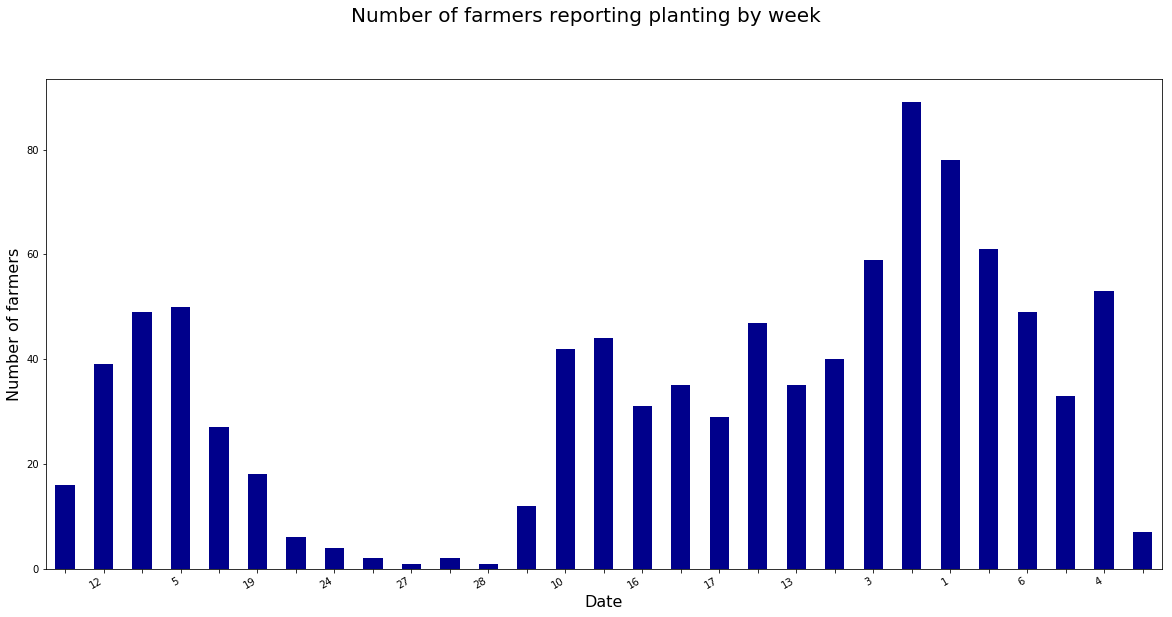

In [102]:
import seaborn as sns

# plot that
plan = plan.sort_values('Week')
plan.set_index('Week')

fig, ax = plt.subplots(1, figsize=(20,10))
ax = plan['Count'].plot(kind='bar', color='darkblue')  #, xticks=plant.index
plt.suptitle('Number of farmers reporting planting by week', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of farmers', fontsize=16)
fig.autofmt_xdate()

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

/Users/kellycaylor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


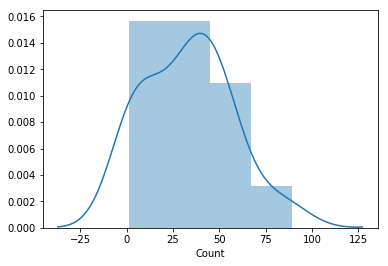

In [103]:
sns.distplot(plan['Count'])

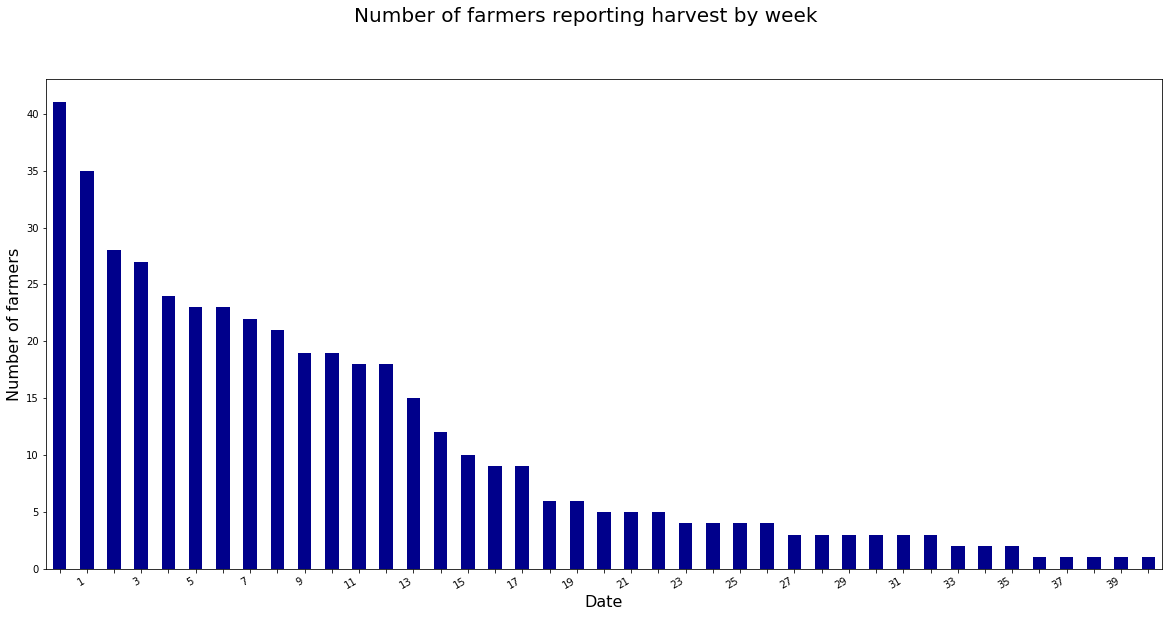

In [104]:
# plot that
#harv = harv.sort_values('Week'); harv
#harv = harv.set_index('Week')

fig, ax = plt.subplots(1, figsize=(20,10))
ax = harv['Count'].plot(kind='bar', color='darkblue') #, xticks=harv.index)
plt.suptitle('Number of farmers reporting harvest by week', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of farmers', fontsize=16)
fig.autofmt_xdate()

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

/Users/kellycaylor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


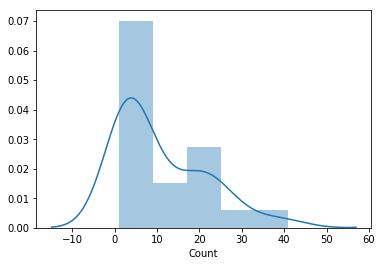

In [105]:
sns.distplot(harv['Count'])